In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/My\ Drive/masters

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
/content/gdrive/My Drive/masters


In [0]:
# %ls ./data/processed
# # T12H-X850M-Y880M_2013-01-01_2015-01-01/
# # T1H-X1700M-Y1760M_2013-01-01_2015-01-01/
# # T1H-X850M-Y880M_2013-01-01_2015-01-01/
# # T24H-X255M-Y220M_2013-01-01_2015-01-01/
# # T24H-X425M-Y440M_2013-01-01_2015-01-01/
# # T24H-X850M-Y880M_2013-01-01_2015-01-01/
# # T24H-X85M-Y110M_2013-01-01_2015-01-01/
# # T3H-X850M-Y880M_2013-01-01_2015-01-01/
# # T6H-X850M-Y880M_2013-01-01_2015-01-01/

T12H-X850M-Y880M_2013-01-01_2015-01-01/
T1H-X1700M-Y1760M_2013-01-01_2015-01-01/
T1H-X850M-Y880M_2013-01-01_2015-01-01/
T24H-X255M-Y220M_2013-01-01_2015-01-01/
T24H-X425M-Y440M_2013-01-01_2015-01-01/
T24H-X850M-Y880M_2013-01-01_2015-01-01/
T24H-X85M-Y110M_2013-01-01_2015-01-01/
T3H-X850M-Y880M_2013-01-01_2015-01-01/
T6H-X850M-Y880M_2013-01-01_2015-01-01/


In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import os
import logging as log
from time import strftime
from copy import deepcopy
from torch import nn, optim
import torch.nn.functional as F
from utils.data_processing import *
from logger.logger import setup_logging
from utils.configs import BaseConf
from utils.metrics import best_threshold
from utils.utils import write_json, Timer
from dataloaders.grid_loader import GridDataLoaders
from datasets.grid_dataset import GridDataGroup
from utils.metrics import PRCurvePlotter, ROCCurvePlotter, LossPlotter, best_threshold, get_y_pred
from sklearn.metrics import accuracy_score, average_precision_score, roc_auc_score
from models.model_result import ModelResult, ModelMetrics
from trainers.generic_trainer import train_model
from utils.plots import im
from utils.utils import pshape, get_data_sub_paths
from models.model_result import save_metrics, compare_models
from models.st_resnet_models import STResNet, STResNetExtra
from models.st_resnet_models import train_epoch_for_st_res_net, train_epoch_for_st_res_net_extra
from models.st_resnet_models import evaluate_st_res_net, evaluate_st_res_net_extra

In [2]:
USE_EXTRA = False # todo move extra model to own notebook

start_date = "2013-01-01"
end_date = "2015-01-01" 

data_dim_str = "T24H-X850M-Y880M" #"T1H-X1700M-Y1760M" # "T24H-X850M-Y880M" # needs to exist
conf = BaseConf()

if USE_EXTRA:
    conf.model_name = "ST-RESNET-Extra"  # needs to be created
else:     
    conf.model_name = "ST-RESNET"  # needs to be created

conf.data_path = f"./data/processed/{data_dim_str}_{start_date}_{end_date}/"

if not os.path.exists(conf.data_path):
    raise Exception(f"Directory ({conf.data_path}) needs to exist.")

conf.model_path =  f"{conf.data_path}models/{conf.model_name}/"
os.makedirs(conf.data_path, exist_ok=True)
os.makedirs(conf.model_path, exist_ok=True)

# logging config is set globally thus we only need to call this in this file
# imported function logs will follow the configuration
setup_logging(save_dir=conf.model_path, log_config='./logger/standard_logger_config.json', default_level=log.INFO)
log.info("=====================================BEGIN=====================================")

info = deepcopy(conf.__dict__)
info["start_time"] = strftime("%Y-%m-%dT%H:%M:%S")

# DATA LOADER SETUP
np.random.seed(conf.seed)
use_cuda = torch.cuda.is_available()
if use_cuda:
    torch.cuda.manual_seed( conf.seed)
else:
    torch.manual_seed(conf.seed)

device = torch.device("cuda:0" if use_cuda else "cpu")
log.info(f"Device: {device}")
info["device"] = device.type
conf.device = device

2019-11-06T21:48:34 | root | INFO | =====================================BEGIN=====================================
2019-11-06T21:48:34 | root | INFO | Device: cpu


## Training loop

In [37]:
# SET THE HYPER PARAMETERS
conf.dropout = 0#0.2
conf.weight_decay = 1e-3
conf.checkpoint = "best" # ["best"|"latest"]
conf.lr = 5e-4
conf.batch_size = 256

# CRIME DATA
data_group = GridDataGroup(data_path=conf.data_path,
                           conf=conf)

loaders = GridDataLoaders(data_group=data_group,
                          conf=conf)

2019-11-06T21:59:41 | root | INFO | 	t_range shape (731,)


2019-11-06T22:10:10 | root | INFO | lr: 		0.0005
2019-11-06T22:10:10 | root | INFO | weight_decay: 	0.001
2019-11-06T22:10:10 | root | INFO | 
 ====================== Training ST-RESNET ====================== 

2019-11-06T22:10:10 | root | INFO | 
 ====================== Config Values ====================== 
{'batch_size': 256,
 'checkpoint': 'latest',
 'data_path': './data/processed/T24H-X850M-Y880M_2013-01-01_2015-01-01/',
 'device': device(type='cpu'),
 'dropout': 0,
 'early_stopping': False,
 'flatten_grid': True,
 'freqstr': '24H',
 'lr': 0.0005,
 'max_epochs': 60,
 'model_name': 'ST-RESNET',
 'model_path': './data/processed/T24H-X850M-Y880M_2013-01-01_2015-01-01/models/ST-RESNET/',
 'n_channels': 10,
 'n_layers': 3,
 'n_steps_c': 3,
 'n_steps_p': 3,
 'n_steps_q': 3,
 'num_workers': 6,
 'resume': True,
 'seed': 3,
 'seq_len': 1,
 'shaper_threshold': 0,
 'shaper_top_k': -1,
 'shuffle': False,
 'sub_sample_test_set': False,
 'sub_sample_train_set': True,
 'sub_sample_validation_set'

2019-11-06T22:11:38 | root | INFO | 	Loss (Dif): 		0.00057

2019-11-06T22:11:38 | root | INFO | Epoch: 0024/0060
2019-11-06T22:11:42 | root | INFO | 	Loss (Trn): 		0.00978
2019-11-06T22:11:42 | root | INFO | 	Loss (Val): 		0.01032
2019-11-06T22:11:42 | root | INFO | 	Loss (Val Best): 	0.01027
2019-11-06T22:11:42 | root | INFO | 	Loss (Dif): 		0.00054

2019-11-06T22:11:42 | root | INFO | Epoch: 0025/0060
2019-11-06T22:11:46 | root | INFO | 	Loss (Trn): 		0.00978
2019-11-06T22:11:46 | root | INFO | 	Loss (Val): 		0.01032
2019-11-06T22:11:46 | root | INFO | 	Loss (Val Best): 	0.01027
2019-11-06T22:11:46 | root | INFO | 	Loss (Dif): 		0.00054

2019-11-06T22:11:46 | root | INFO | Epoch: 0026/0060
2019-11-06T22:11:50 | root | INFO | 	Loss (Trn): 		0.00978
2019-11-06T22:11:50 | root | INFO | 	Loss (Val): 		0.01033
2019-11-06T22:11:50 | root | INFO | 	Loss (Val Best): 	0.01027
2019-11-06T22:11:50 | root | INFO | 	Loss (Dif): 		0.00055

2019-11-06T22:11:50 | root | INFO | Epoch: 0027/0060
2019-

2019-11-06T22:13:26 | root | INFO | 	Loss (Dif): 		0.00050

2019-11-06T22:13:26 | root | INFO | Epoch: 0052/0060
2019-11-06T22:13:30 | root | INFO | 	Loss (Trn): 		0.00975
2019-11-06T22:13:30 | root | INFO | 	Loss (Val): 		0.01033
2019-11-06T22:13:30 | root | INFO | 	Loss (Val Best): 	0.01016
2019-11-06T22:13:30 | root | INFO | 	Loss (Dif): 		0.00058

2019-11-06T22:13:30 | root | INFO | Epoch: 0053/0060
2019-11-06T22:13:34 | root | INFO | 	Loss (Trn): 		0.00981
2019-11-06T22:13:34 | root | INFO | 	Loss (Val): 		0.01087
2019-11-06T22:13:34 | root | INFO | 	Loss (Val Best): 	0.01016
2019-11-06T22:13:34 | root | INFO | 	Loss (Dif): 		0.00106

2019-11-06T22:13:34 | root | INFO | Epoch: 0054/0060
2019-11-06T22:13:38 | root | INFO | 	Loss (Trn): 		0.00984
2019-11-06T22:13:38 | root | INFO | 	Loss (Val): 		0.01062
2019-11-06T22:13:38 | root | INFO | 	Loss (Val Best): 	0.01016
2019-11-06T22:13:38 | root | INFO | 	Loss (Dif): 		0.00079

2019-11-06T22:13:38 | root | INFO | Epoch: 0055/0060
2019-

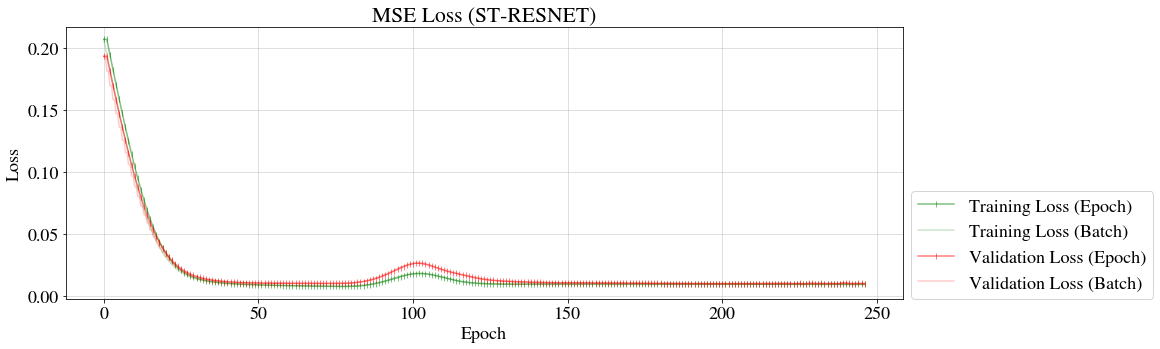

In [44]:
conf.checkpoint = "latest"#"best"
conf.resume = True
conf.freqstr = data_group.t_range.freqstr  
conf.early_stopping = False
conf.max_epochs = 60

# SET LOSS FUNCTION
# size averaged - so more epochs or larger lr for smaller batches
loss_function = nn.MSELoss()  

# SETUP MODEL
dataset = loaders.train_loader.dataset
_, h_size, w_size = dataset.crimes.shape
_, n_ext_features = dataset.time_vectors.shape


# todo setup - hyper-optimiser
conf.n_layers = 3  # number of res-unit layers
conf.n_channels = 10 # inner channel size of the res-units 

if USE_EXTRA:
    train_epoch_fn = train_epoch_for_st_res_net_extra
    evaluate_fn = evaluate_st_res_net_extra
    model = STResNetExtra(n_layers=conf.n_layers,
                          n_channels=conf.n_channels,
                          y_size=h_size,
                          x_size=w_size,

                          lc=dataset.n_steps_c,
                          lp=dataset.n_steps_p,
                          lq=dataset.n_steps_q,

                          n_ext_features=n_ext_features,
                          n_demog_features=37,
                          n_demog_channels=10,
                          n_demog_layers=3,

                          n_gsv_features=512,
                          n_gsv_channels=10,
                          n_gsv_layers=3)
else:
    train_epoch_fn = train_epoch_for_st_res_net
    evaluate_fn = evaluate_st_res_net
    model = STResNet(n_layers=conf.n_layers,
                     n_channels=conf.n_channels,
                     y_size=h_size,
                     x_size=w_size,

                     lc=dataset.n_steps_c,
                     lp=dataset.n_steps_p,
                     lq=dataset.n_steps_q,

                     n_ext_features=n_ext_features)    
    
# todo implement model_arch for res-net
model.to(conf.device)

# SETUP OPTIMISER
parameters = model.parameters()
# todo (optional): setup model parameters dynamically 

optimiser = optim.Adam(params=parameters, lr=conf.lr, weight_decay=conf.weight_decay)

if conf.resume:
    try:
        # resume from previous check point or resume from best validaton score checkpoint
        # load model state
        model_state_dict = torch.load(f"{conf.model_path}model_{conf.checkpoint}.pth",
                                      map_location=conf.device.type)
        model.load_state_dict(model_state_dict)
        
        # load optimiser state
        optimiser_state_dict = torch.load(f"{conf.model_path}optimiser_{conf.checkpoint}.pth",
                                          map_location=conf.device.type)
        optimiser.load_state_dict(optimiser_state_dict) 

        # new optimiser hyper-parameters
        optimiser.param_groups[0]['lr'] = conf.lr
        optimiser.param_groups[0]['weight_decay'] = conf.weight_decay

    except Exception as e:
        log.error(f"Nothing to resume from, training from scratch \n\t-> {e}")
        
log.info(f"lr: \t\t{optimiser.param_groups[0]['lr']}")
log.info(f"weight_decay: \t{optimiser.param_groups[0]['weight_decay']}")
trn_epoch_losses, val_epoch_losses, stopped_early = train_model(model=model,
                                           optimiser=optimiser,
                                           loaders=loaders,
                                           train_epoch_fn=train_epoch_fn,
                                           loss_fn=loss_function,
                                           conf=conf)    

print(f"stopped_early: {stopped_early}") # use the current epoch instead
# if stopped_early -> continue with best_model - new hyper-parameters -> no n 

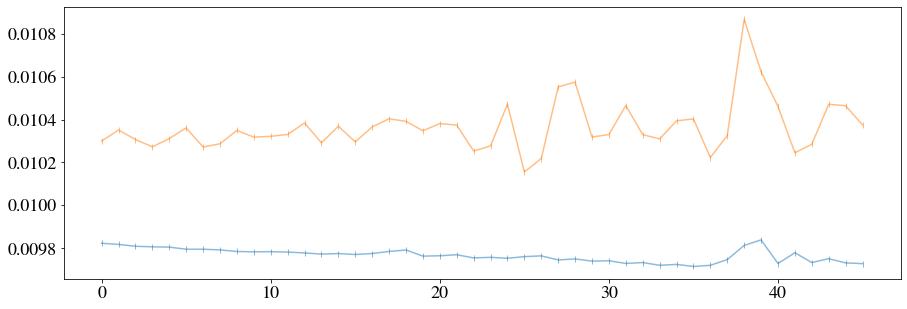

In [45]:
plt.figure(figsize=(15,5))
for x in [trn_epoch_losses, val_epoch_losses]:
    plt.plot(x[200:],marker='|',alpha=.5)
plt.show()

## Evaluation

In [46]:
# Load latest or best validation model
# conf.checkpoint = "latest"
conf.checkpoint = "best"

log.info(f"Loading model from checkpoint ({conf.checkpoint}) for evaluation")

# resume from previous check point or resume from best validaton score checkpoint
# load model state
model_state_dict = torch.load(f"{conf.model_path}model_{conf.checkpoint}.pth",
                                map_location=conf.device.type)
model.load_state_dict(model_state_dict)

2019-11-06T22:14:52 | root | INFO | Loading model from checkpoint (best) for evaluation


<All keys matched successfully>

```
        MODEL METRICS
            Model Name: ST-RESNET - lr = 5e-4 ,wd = 1e-8
                ROC AUC:            0.8020111294391816
                Recall:             0.8765201927489674
                Precision:          0.6032353899148218
                Average Precision:  0.7594655348164152
                Accuracy:           0.688244912558603
                MCC:                0.4301498407879584
                
        MODEL METRICS
            Model Name: ST-RESNET - lr = 5e-4 ,wd = 1e-8
                ROC AUC:            0.8023485145892673
                Recall:             0.8634407985314364
                Precision:          0.6110113157761201
                Average Precision:  0.7583870184631581
                Accuracy:           0.6943638941761091
                MCC:                0.4342971968222662                                 
```

2019-11-06T22:14:58 | root | INFO | f1_score: 0.7239305315389821 at index 77045, new threshold 0.10304154455661774
2019-11-06T22:15:01 | root | INFO | 
        MODEL METRICS
            Model Name: ST-RESNET
                ROC AUC:            0.8038603011437172                
                Average Precision:  0.7637985620130209
                Precision:          0.6287123299654463
                Recall:             0.8245898347865993
                Accuracy:           0.7049986586783511
                MCC:                0.43719342956874835          
        
2019-11-06T22:15:01 | root | INFO | 
        MODEL RESULT
            Model Name: ST-RESNET
                ROC AUC:            0.8038603011437172
                Average Precision:  0.7637985620130209                
                Precision:          0.6287123299654463
                Recall:             0.8245898347865993
                Accuracy:           0.7049986586783511
                MCC:                0.43719

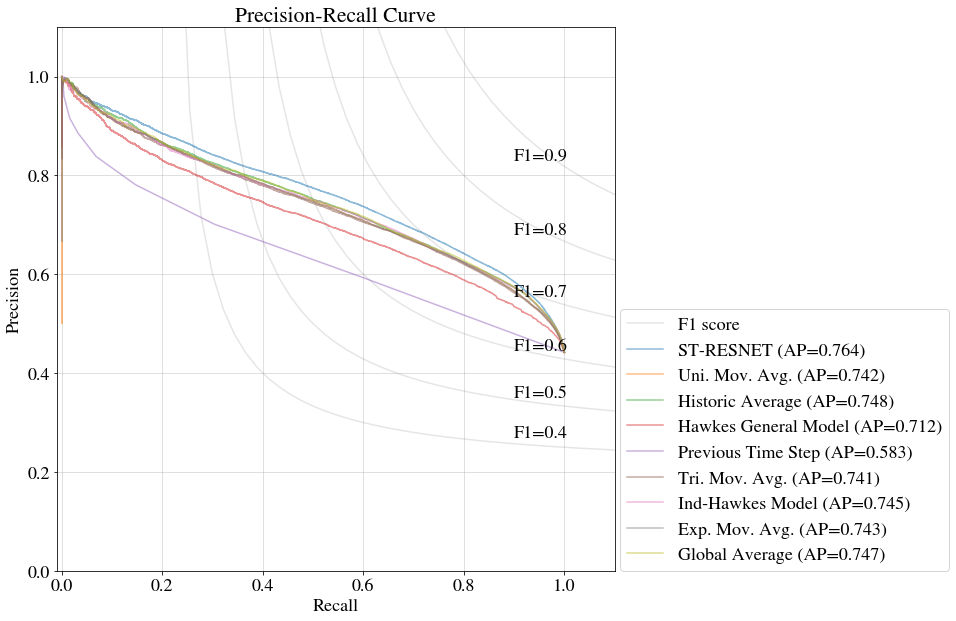

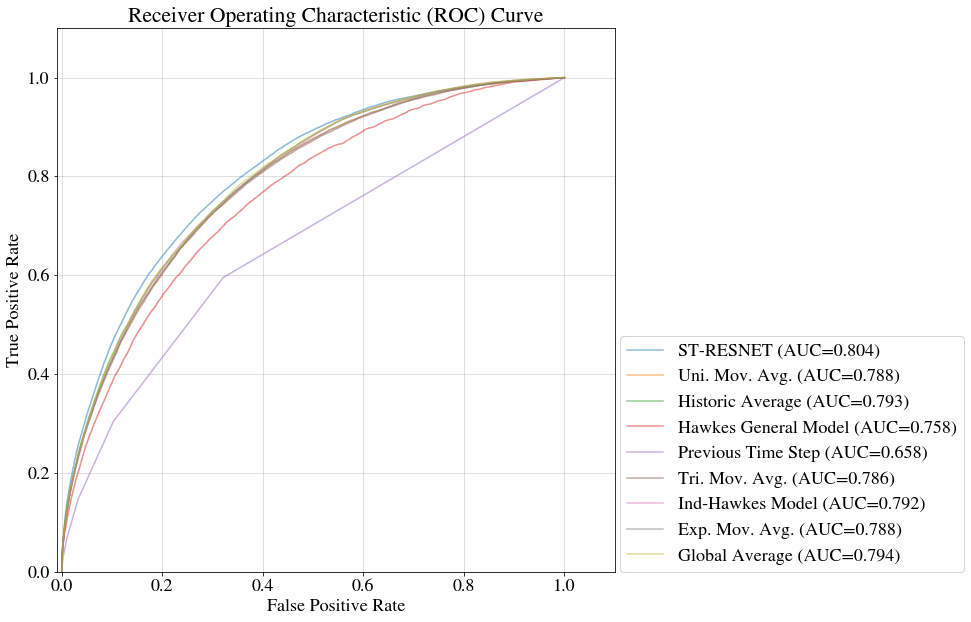

,ROC AUC,Avg. Precision,Precision,Recall,F1 Score,Accuracy,Matthews Corrcoef
Model Name,,,,,,,
Historic Average,0.792899,0.747870,0.590636,0.870548,0.804560,0.676171,0.409349
Global Average,0.793560,0.746980,0.595336,0.860057,0.799541,0.679828,0.410530
ST-RESNET,0.803860,0.763799,0.628712,0.824590,0.793031,0.704999,0.437193
Ind-Hawkes Model,0.792012,0.745141,0.604870,0.839686,0.789594,0.686769,0.413414
Exp. Mov. Avg.,0.788310,0.743067,0.604903,0.834178,0.785991,0.685958,0.409981
Uni. Mov. Avg.,0.788279,0.742474,0.604673,0.834849,0.785957,0.685829,0.410025
Tri. Mov. Avg.,0.786171,0.741144,0.601788,0.835898,0.785674,0.683060,0.405902
Hawkes General Model,0.758150,0.712040,0.566255,0.847584,0.773922,0.645753,0.350019
Previous Time Step,0.658416,0.583346,0.441895,1.000000,0.736852,0.441895,0.000000


In [47]:
trn_y_counts, trn_y_true, trn_probas_pred, trn_t_range = evaluate_fn(model=model,
                                                                           batch_loader=loaders.train_loader,
                                                                           conf=conf) 
thresh = best_threshold(trn_y_true, trn_probas_pred) 

tst_y_counts, tst_y_true, tst_probas_pred, tst_t_range = evaluate_fn(model=model,
                                                           batch_loader=loaders.test_loader,
                                                           conf=conf)


tst_y_true = np.expand_dims(tst_y_true, axis=1)
tst_probas_pred = np.expand_dims(tst_probas_pred, axis=1) 

tst_y_true = data_group.shaper.squeeze(tst_y_true)
tst_probas_pred = data_group.shaper.squeeze(tst_probas_pred)


tst_y_pred = get_y_pred(thresh, tst_probas_pred)
save_metrics(y_true=tst_y_true,
             y_pred=tst_y_pred,
             probas_pred=tst_probas_pred,
             t_range=tst_t_range,
             shaper=data_group.shaper,                
             conf=conf)
compare_models(data_path=conf.data_path)

In [64]:
models_results = get_models_results(data_path=conf.data_path)

719

In [76]:
targets = [m.shaper for m in models_results]
for t in targets:
    print(t.l)

742
719
719
719
719
719
719
719
719


----------------------------------------------------------------------------------------------------

## All in one

In [51]:
import matplotlib.pyplot as plt
%matplotlib inline
import os
import logging as log
from time import strftime
from copy import deepcopy
from torch import nn, optim
import torch.nn.functional as F
from utils.data_processing import *
from logger.logger import setup_logging
from utils.configs import BaseConf
from utils.utils import write_json, Timer
from dataloaders.grid_loader import GridDataLoaders
from datasets.grid_dataset import GridDataGroup
from utils.metrics import PRCurvePlotter, ROCCurvePlotter, LossPlotter, best_threshold, get_y_pred
from sklearn.metrics import accuracy_score, average_precision_score, roc_auc_score
from models.model_result import ModelResult, ModelMetrics
from trainers.generic_trainer import train_model
from utils.plots import im
from utils.utils import pshape, get_data_sub_paths
from models.model_result import save_metrics, compare_models, get_models_metrics, get_models_results
from models.st_resnet_models import STResNet, STResNetExtra
from models.st_resnet_models import train_epoch_for_st_res_net, train_epoch_for_st_res_net_extra
from models.st_resnet_models import evaluate_st_res_net, evaluate_st_res_net_extra

2019-11-06T17:16:23 | root | INFO | =====================================BEGIN=====================================
2019-11-06T17:16:23 | root | INFO | Device: cpu
2019-11-06T17:16:23 | root | INFO | 	t_range shape (731,)
2019-11-06T17:16:23 | root | INFO | 
 ====================== Training ST-RESNET ====================== 

2019-11-06T17:16:23 | root | INFO | 
 ====================== Config Values ====================== 
{'batch_size': 256,
 'checkpoint': 'best',
 'data_path': './data/processed/T24H-X850M-Y880M_2013-01-01_2015-01-01/',
 'device': device(type='cpu'),
 'dropout': 0,
 'early_stopping': False,
 'flatten_grid': True,
 'freqstr': '24H',
 'lr': 0.001,
 'max_epochs': 20,
 'model_name': 'ST-RESNET',
 'model_path': './data/processed/T24H-X850M-Y880M_2013-01-01_2015-01-01/models/ST-RESNET/',
 'n_channels': 10,
 'n_layers': 3,
 'n_steps_c': 3,
 'n_steps_p': 3,
 'n_steps_q': 3,
 'num_workers': 6,
 'resume': False,
 'seed': 3,
 'seq_len': 1,
 'shaper_threshold': 0,
 'shaper_top_k':

2019-11-06T17:19:32 | root | INFO | 
                      Accuracy   ROC AUC  Avg. Precision    Recall  Precision  \
Model Name                                                                      
Historic Average      0.676171  0.792898        0.747870  0.870548   0.590636   
ST-RESNET             0.702859  0.803479        0.760436  0.846561   0.622334   
Global Average        0.679828  0.793560        0.746980  0.860057   0.595336   
Ind-Hawkes Model      0.684194  0.792523        0.745954  0.849653   0.600899   
Kang FNN              0.677304  0.785098        0.733179  0.852859   0.593924   
Rolling Average       0.663718  0.763296        0.717494  0.830361   0.584052   
Hawkes General Model  0.660653  0.753543        0.707105  0.804511   0.584266   
ST-RESNET-Extra       0.719153  0.797580        0.756477  0.743848   0.665166   
Previous Time Step    0.441895  0.658416        0.583346  1.000000   0.441895   

                      F1 Score  Matthews Corrcoef  
Model Name         

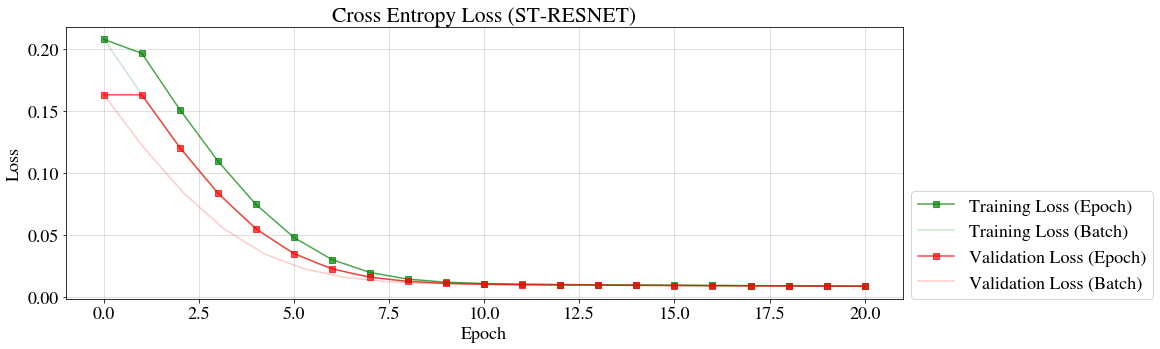

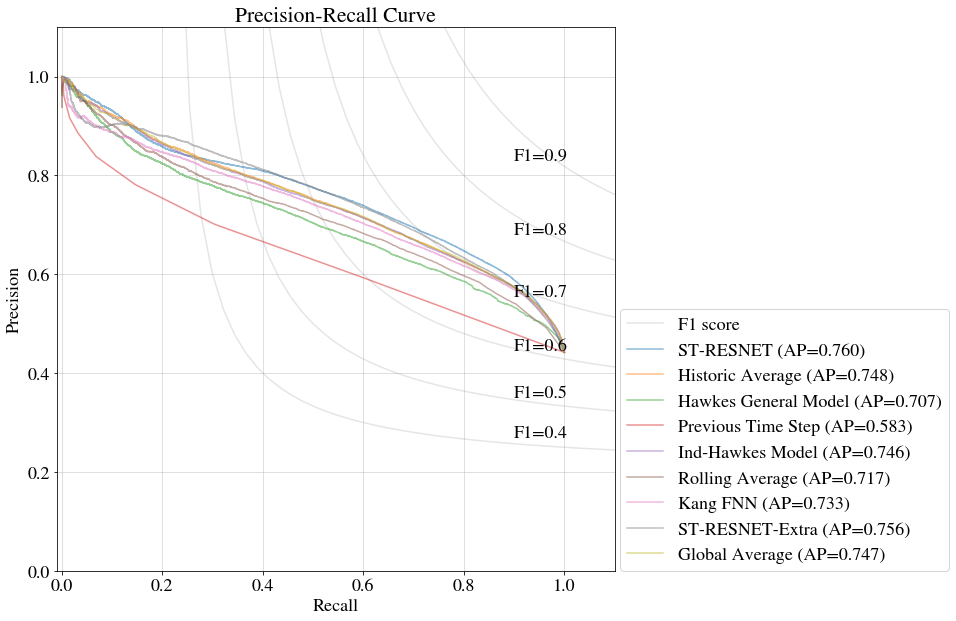

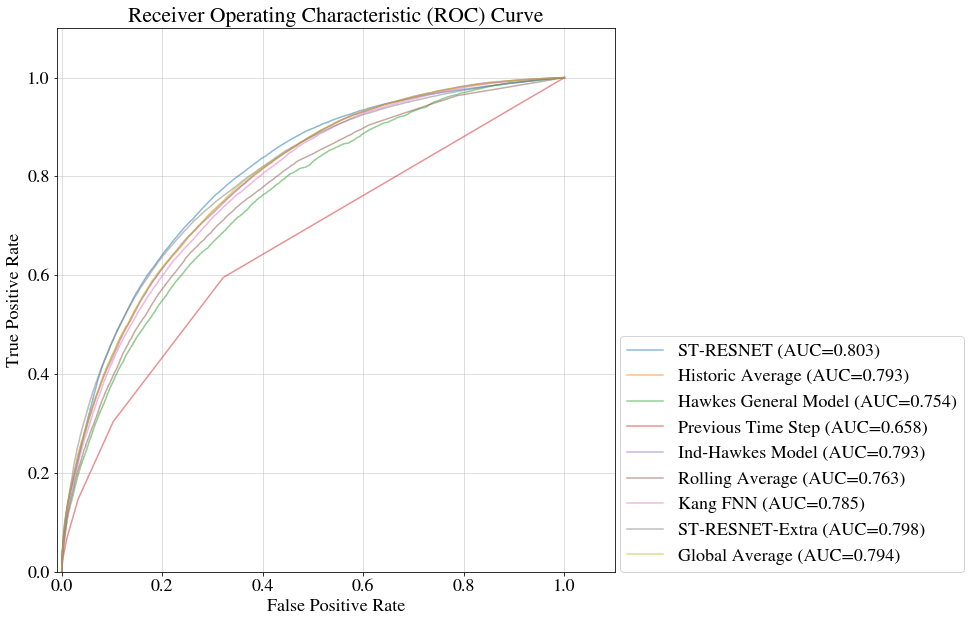

2019-11-06T17:19:33 | root | INFO | =====================================BEGIN=====================================
2019-11-06T17:19:33 | root | INFO | Device: cpu
2019-11-06T17:19:33 | root | INFO | 	t_range shape (731,)
2019-11-06T17:19:34 | root | INFO | 
 ====================== Training ST-RESNET-Extra ====================== 

2019-11-06T17:19:34 | root | INFO | 
 ====================== Config Values ====================== 
{'batch_size': 256,
 'checkpoint': 'best',
 'data_path': './data/processed/T24H-X850M-Y880M_2013-01-01_2015-01-01/',
 'device': device(type='cpu'),
 'dropout': 0,
 'early_stopping': False,
 'flatten_grid': True,
 'freqstr': '24H',
 'lr': 0.001,
 'max_epochs': 20,
 'model_name': 'ST-RESNET-Extra',
 'model_path': './data/processed/T24H-X850M-Y880M_2013-01-01_2015-01-01/models/ST-RESNET-Extra/',
 'n_channels': 10,
 'n_layers': 3,
 'n_steps_c': 3,
 'n_steps_p': 3,
 'n_steps_q': 3,
 'num_workers': 6,
 'resume': False,
 'seed': 3,
 'seq_len': 1,
 'shaper_threshold': 0

2019-11-06T17:22:45 | root | INFO | 
        MODEL RESULT
            Model Name: ST-RESNET-Extra
                ROC AUC:            0.788996037923314
                Recall:             0.8133174621385957
                Precision:          0.6178207251176573
                Average Precision:  0.7464906073580471
                Accuracy:           0.6927862444271279
                MCC:                0.4130652245687988          
        
2019-11-06T17:22:47 | root | INFO | 
                      Accuracy   ROC AUC  Avg. Precision    Recall  Precision  \
Model Name                                                                      
Historic Average      0.676171  0.792898        0.747870  0.870548   0.590636   
ST-RESNET             0.702859  0.803479        0.760436  0.846561   0.622334   
Global Average        0.679828  0.793560        0.746980  0.860057   0.595336   
Ind-Hawkes Model      0.684194  0.792523        0.745954  0.849653   0.600899   
Kang FNN              0.677304 

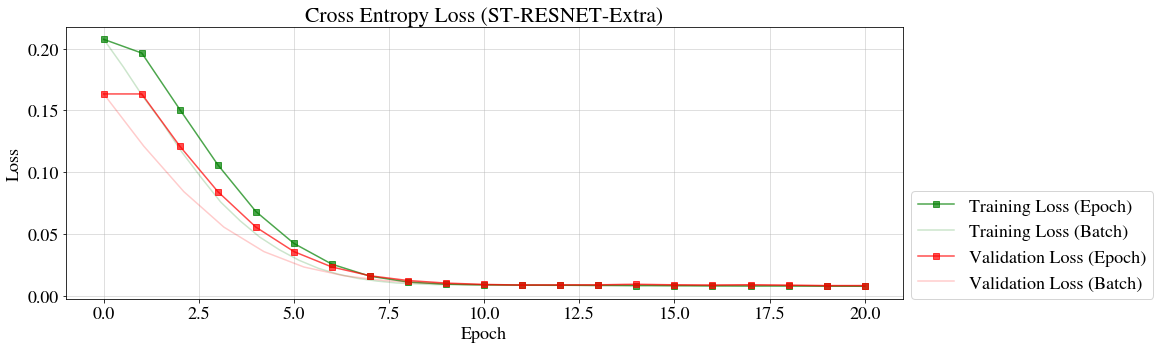

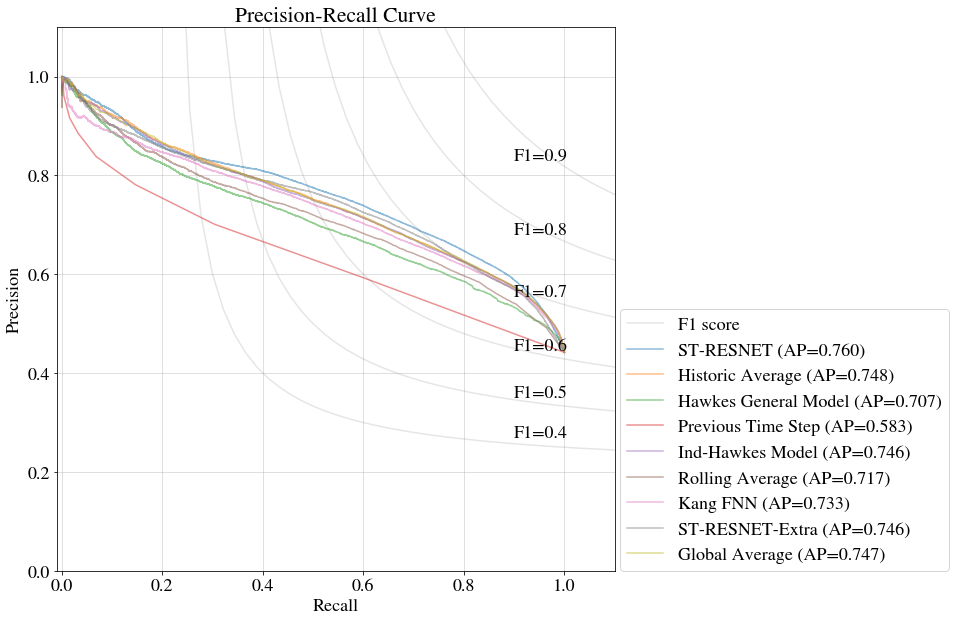

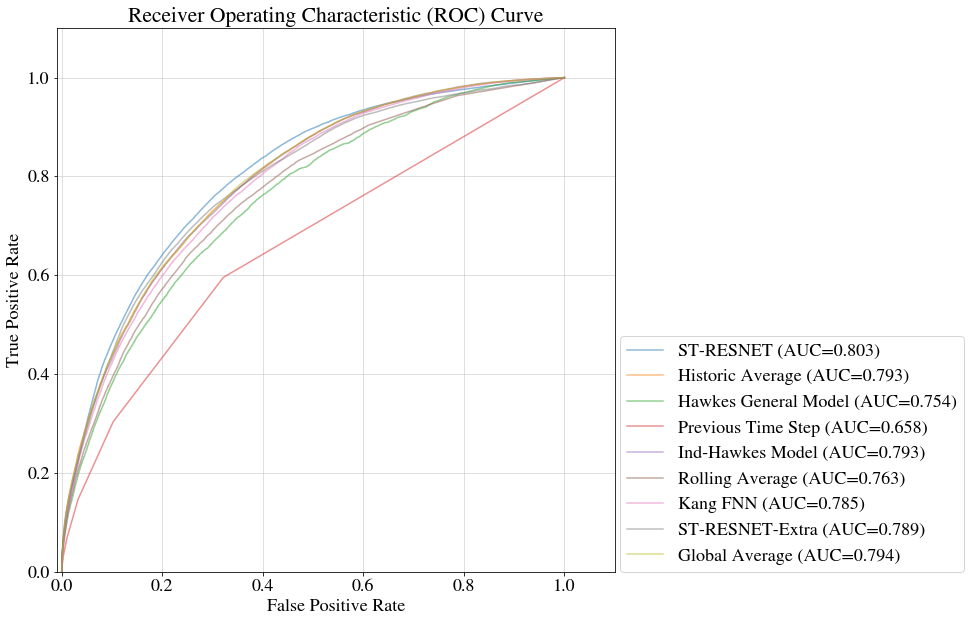

In [4]:
for data_sub_path in get_data_sub_paths():
    log.info(f"\n========================= {data_sub_path} =========================\n")    
    for USE_EXTRA in [False, True]:
        conf = BaseConf()
        conf.data_path = f"./data/processed/{data_sub_path}/"

        if USE_EXTRA:
            conf.model_name = "ST-RESNET-Extra"  # needs to be created
        else:     
            conf.model_name = "ST-RESNET"  # needs to be created

        if not os.path.exists(conf.data_path):
            raise Exception(f"Directory ({conf.data_path}) needs to exist.")

        conf.model_path =  f"{conf.data_path}models/{conf.model_name}/"
        os.makedirs(conf.data_path, exist_ok=True)
        os.makedirs(conf.model_path, exist_ok=True)

        # logging config is set globally thus we only need to call this in this file
        # imported function logs will follow the configuration
        setup_logging(save_dir=conf.model_path, log_config='./logger/standard_logger_config.json', default_level=log.INFO)
        log.info("=====================================BEGIN=====================================")

        info = deepcopy(conf.__dict__)
        info["start_time"] = strftime("%Y-%m-%dT%H:%M:%S")

        # DATA LOADER SETUP
        np.random.seed(conf.seed)
        use_cuda = torch.cuda.is_available()
        if use_cuda:
            torch.cuda.manual_seed( conf.seed)
        else:
            torch.manual_seed(conf.seed)

        device = torch.device("cuda:0" if use_cuda else "cpu")
        log.info(f"Device: {device}")
        info["device"] = device.type
        conf.device = device

        # SET THE HYPER PARAMETERS
        conf.dropout = 0#0.2
        conf.weight_decay = 0
        conf.checkpoint = "best" # ["best"|"latest"]
        conf.lr = 1e-3
        conf.batch_size = 256

        # CRIME DATA
        data_group = GridDataGroup(data_path=conf.data_path,
                                   conf=conf)

        loaders = GridDataLoaders(data_group=data_group,
                                  conf=conf)

        conf.resume = False
        conf.freqstr = data_group.t_range.freqstr  
        conf.early_stopping = False
        conf.max_epochs = 20

        # SET LOSS FUNCTION
        # size averaged - so more epochs or larger lr for smaller batches
        loss_function = nn.MSELoss()  

        # SETUP MODEL
        dataset = loaders.train_loader.dataset
        _, h_size, w_size = dataset.crimes.shape
        _, n_ext_features = dataset.time_vectors.shape


        # todo setup - hyper-optimiser
        conf.n_layers = 3  # number of res-unit layers
        conf.n_channels = 10 # inner channel size of the res-units 

        if USE_EXTRA:
            train_epoch_fn = train_epoch_for_st_res_net_extra
            evaluate_fn = evaluate_st_res_net_extra
            model = STResNetExtra(n_layers=conf.n_layers,
                                  n_channels=conf.n_channels,
                                  y_size=h_size,
                                  x_size=w_size,

                                  lc=dataset.n_steps_c,
                                  lp=dataset.n_steps_p,
                                  lq=dataset.n_steps_q,

                                  n_ext_features=n_ext_features,
                                  n_demog_features=37,
                                  n_demog_channels=10,
                                  n_demog_layers=3,

                                  n_gsv_features=512,
                                  n_gsv_channels=10,
                                  n_gsv_layers=3)
        else:
            train_epoch_fn = train_epoch_for_st_res_net
            evaluate_fn = evaluate_st_res_net
            model = STResNet(n_layers=conf.n_layers,
                             n_channels=conf.n_channels,
                             y_size=h_size,
                             x_size=w_size,

                             lc=dataset.n_steps_c,
                             lp=dataset.n_steps_p,
                             lq=dataset.n_steps_q,

                             n_ext_features=n_ext_features)    

        # todo implement model_arch for res-net
        model.to(conf.device)

        # SETUP OPTIMISER
        parameters = model.parameters()
        # todo (optional): setup model parameters dynamically 

        optimiser = optim.Adam(params=parameters, lr=conf.lr, weight_decay=conf.weight_decay)

        if conf.resume:
            try:
                # resume from previous check point or resume from best validaton score checkpoint
                # load model state
                model_state_dict = torch.load(f"{conf.model_path}model_{conf.checkpoint}.pth",
                                              map_location=conf.device.type)
                model.load_state_dict(model_state_dict)

                # load optimiser state
                optimiser_state_dict = torch.load(f"{conf.model_path}optimiser_{conf.checkpoint}.pth",
                                                  map_location=conf.device.type)
                optimiser.load_state_dict(optimiser_state_dict) 

        #         # new optimiser hyper-parameters
        #         optimiser.param_groups[0]['lr'] = conf.lr
        #         optimiser.param_groups[0]['weight_decay'] = conf.weight_decay

            except Exception as e:
                log.error(f"Nothing to resume from, training from scratch \n\t-> {e}")

        trn_epoch_losses, val_epoch_losses, stopped_early = train_model(model=model,
                                                   optimiser=optimiser,
                                                   loaders=loaders,
                                                   train_epoch_fn=train_epoch_fn,
                                                   loss_fn=loss_function,
                                                   conf=conf)    

        print(f"stopped_early: {stopped_early}") # use the current epoch instead
        # if stopped_early -> continue with best_model - new hyper-parameters -> no n 
        # Load latest or best validation model
        # conf.checkpoint = "latest"
        conf.checkpoint = "best"

        log.info(f"Loading model from checkpoint ({conf.checkpoint}) for evaluation")

        # resume from previous check point or resume from best validaton score checkpoint
        # load model state
        model_state_dict = torch.load(f"{conf.model_path}model_{conf.checkpoint}.pth",
                                        map_location=conf.device.type)
        model.load_state_dict(model_state_dict)

        trn_y_counts, trn_y_true, trn_probas_pred, trn_t_range = evaluate_fn(model=model,
                                                                                   batch_loader=loaders.train_loader,
                                                                                   conf=conf) 
        thresh = best_threshold(trn_y_true, trn_probas_pred) 

        tst_y_counts, tst_y_true, tst_probas_pred, tst_t_range = evaluate_fn(model=model,
                                                                   batch_loader=loaders.test_loader,
                                                                   conf=conf)


        tst_y_true = np.expand_dims(tst_y_true, axis=1)
        tst_probas_pred = np.expand_dims(tst_probas_pred, axis=1) 

        tst_y_true = data_group.shaper.squeeze(tst_y_true)
        tst_probas_pred = data_group.shaper.squeeze(tst_probas_pred)


        tst_y_pred = get_y_pred(thresh, tst_probas_pred)
        save_metrics(y_true=tst_y_true,
                     y_pred=tst_y_pred,
                     probas_pred=tst_probas_pred,
                     t_range=tst_t_range,
                     shaper=data_group.shaper,                
                     conf=conf)
        compare_models(data_path=conf.data_path)

In [0]:
for data_sub_path in get_data_sub_paths():
    log.info(f"{data_sub_path}\n")
    data_path = f"./data/processed/{data_sub_path}/"

    models_metrics = get_models_metrics(data_path)
    metrics_table = get_metrics_table(models_metrics)
    print(metrics_table)
    print("\n===================================================================================================\n")